In [1]:
# IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.spatial.transform import Rotation as R
from typing import List, Tuple
import os

# %matplotlib widget

In [2]:
# HELPER FUNCTIONS

# load dataset
def load_data(data_path, key_path):
    data = np.load(data_path, allow_pickle=True)
    key = np.load(key_path, allow_pickle=True).item()
    print("Loaded data and key.")
    print("Data shape: ", data.shape)
    print("Key length: ", len(key))
    return data, key

# plot force, position, and raw sensor data
def plot_initial_data(plot_data, plot_key):

    # plot force data over time
    force_fig, force_ax = plt.subplots(1,1)
    force_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["Fx"]], label="Fx")
    force_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["Fy"]], label="Fy")
    force_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["Fz"]], label="Fz")
    force_ax.set_title("Force")
    force_ax.legend()
    plt.tight_layout()
    plt.show()

    # plot x,y,z location over time
    loc_fig, loc_ax = plt.subplots(1,1)
    loc_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["x_act"]], label="x")
    loc_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["y1_act"]], label="y")
    loc_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["z_act"]], label="z")
    loc_ax.set_title("Location")
    loc_ax.legend()
    plt.tight_layout()
    plt.show()

    # plot all sensor data over time
    sensor_fig, sensor_ax = plt.subplots(3,12, figsize=(80,20))
    sensor_keys = []
    for k in list(plot_key.keys()):
        if 's' in k: # TODO: this might break if we add more columns to the dataset
            sensor_keys.append(k)
    k = 0
    for i in range(3):
        for j in range(12):
            cur_key = sensor_keys[k]
            sensor_ax[i,j].plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key[cur_key]], label=cur_key)
            sensor_ax[i,j].set_title(cur_key)
            sensor_ax[i,j].set_ylim(-35000, 35000)
            k += 1
    plt.show()

def plot_single_sensor_data(input_data, input_key, sensor_to_plot):
    fig, ax = plt.subplots(3,1)
    ax[0].plot(input_data[:, input_key["time"]], input_data[:, input_key["Fz"]], label="Fz")
    ax[0].set_title("Fz")
    ax[1].plot(input_data[:, input_key["time"]], input_data[:, input_key["z_act"]], label="z")
    ax[1].set_title("z")
    ax[2].plot(input_data[:, input_key["time"]], input_data[:, input_key[sensor_to_plot]], label=sensor_to_plot)
    ax[2].set_title(sensor_to_plot)
    plt.tight_layout()
    plt.show()


Loaded data and key.
Data shape:  (12098, 51)
Key length:  51


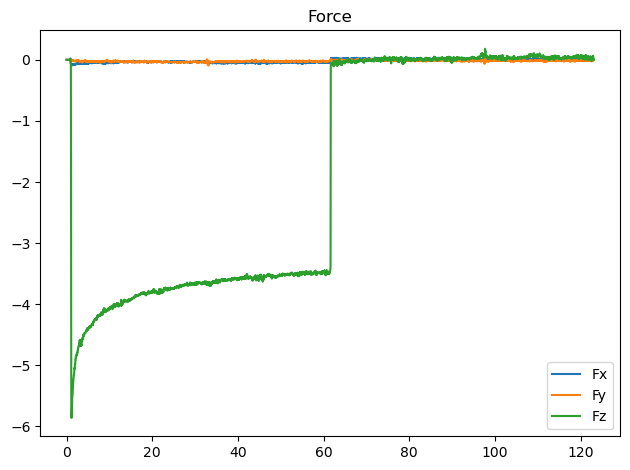

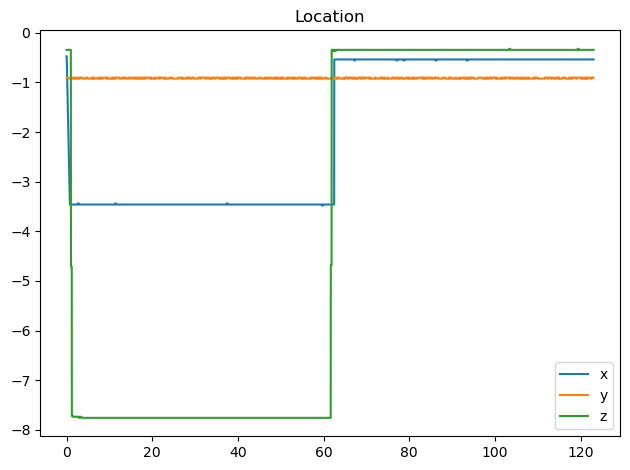

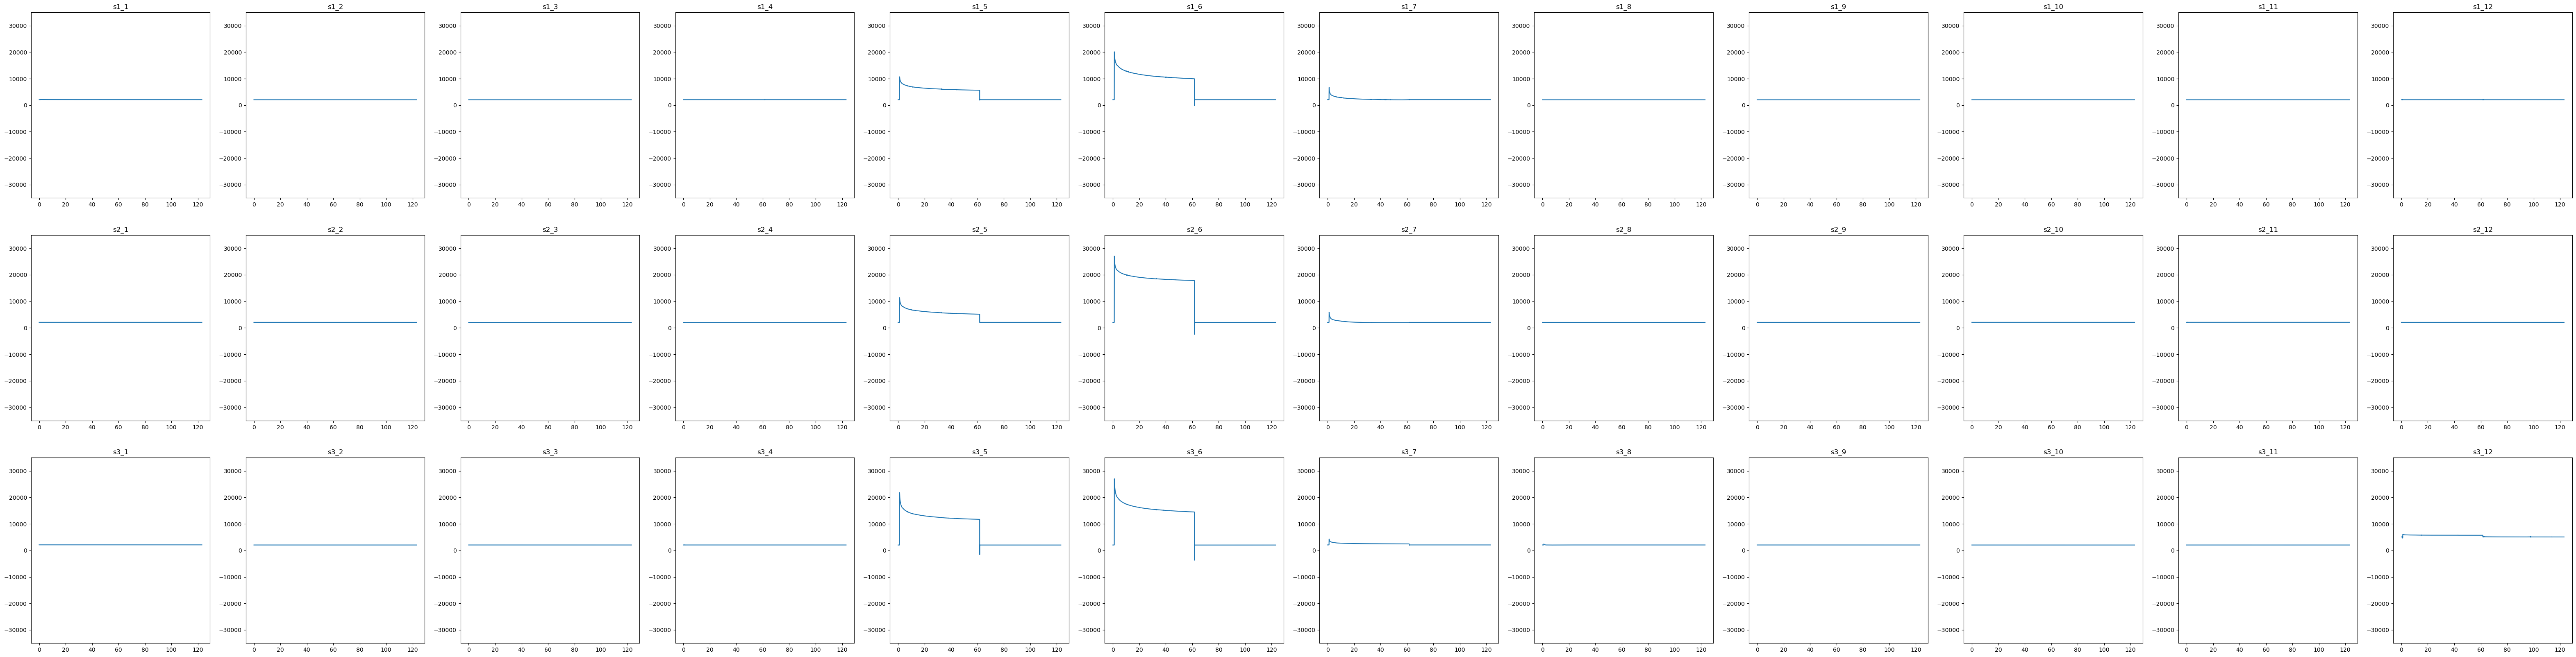

In [3]:
test_path = "data/2024-11-15_14-45-37.807944_SINGLEPRESS_BP_COMBO"

# load data
data_path = os.path.join(test_path, "processed.npy")
key_path = os.path.join(test_path, "key.npy")
data, key = load_data(data_path, key_path)

plot_initial_data(data, key)

Estimated time constant: 3.3562010000000555 seconds.


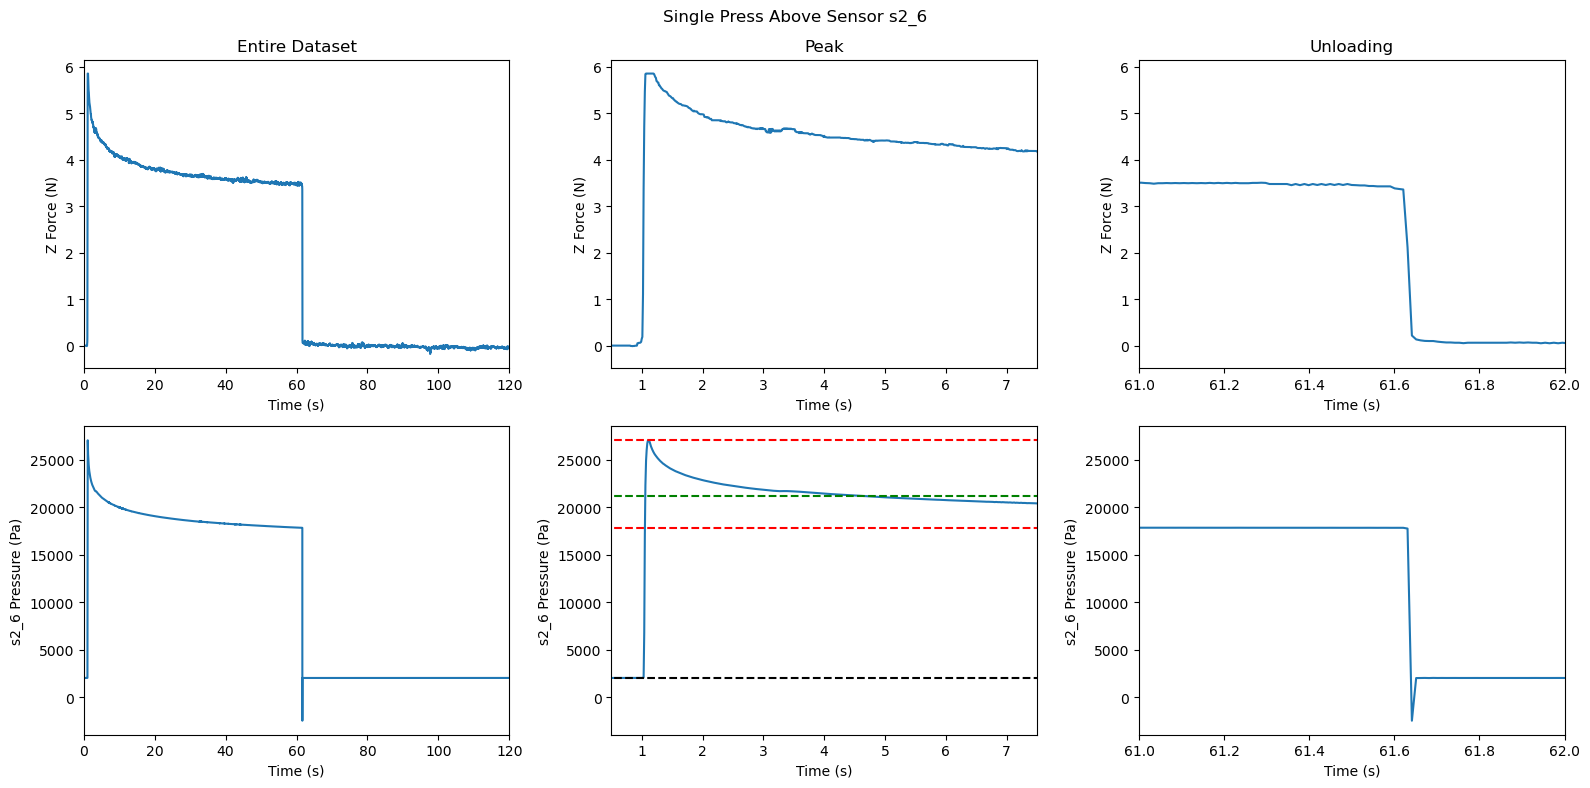

In [ ]:
# PLOT FOR S2_6, DIRECTLY UNDER STIMULUS

# fitting exponential time constant to peak decay
max_pressure = np.max(data[:, key["s2_6"]])
max_pressure_idx = np.argmax(data[:, key["s2_6"]])
max_pressure_time = data[max_pressure_idx, key["time"]]
stable_pressure = np.mean(data[(data[:, key["time"]] > 60.0) & (data[:, key["time"]] < 61.0), key["s2_6"]])
one_tc_pressure = stable_pressure + (1.0-0.632)*(max_pressure - stable_pressure)
one_tc_pressure_idx = np.argmin(np.abs(data[:, key["s2_6"]] - one_tc_pressure))
time_const_est = data[one_tc_pressure_idx, key["time"]] - max_pressure_time
print("Estimated time constant: "+str(time_const_est)+" seconds.")

fig, ax = plt.subplots(2,3, figsize=(16,8))
sensor_to_plot = "s2_6"

# start with generic plot
ax[0,0].plot(data[:, key["time"]], -1.0*data[:, key["Fz"]])
ax[0,0].set_xlim(0.0, 120.0)
ax[0,0].set_title("Entire Dataset")
ax[0,0].set_ylabel("Z Force (N)")
ax[0,0].set_xlabel("Time (s)")
ax[1,0].plot(data[:, key["time"]], data[:, key[sensor_to_plot]])
ax[1,0].set_xlim(0.0, 120.0)
ax[1,0].set_ylabel(sensor_to_plot+" Pressure (Pa)")
ax[1,0].set_xlabel("Time (s)")

# zoom into force peak
ax[0,1].plot(data[:, key["time"]], -1.0*data[:, key["Fz"]])
ax[0,1].set_title("Peak")
ax[0,1].set_xlim(0.5, 7.5)
ax[0,1].set_ylabel("Z Force (N)")
ax[0,1].set_xlabel("Time (s)")
ax[1,1].plot(data[:, key["time"]], data[:, key[sensor_to_plot]])
ax[1,1].hlines([27020, 17800], 0.0, 120.0, color='r', linestyle='--')
ax[1,1].hlines([one_tc_pressure], 0.0, 120.0, color='g', linestyle='--')
ax[1,1].hlines([2000], 0.0, 120.0, color='k', linestyle='--')
ax[1,1].set_xlim(0.5, 7.5)
ax[1,1].set_ylabel(sensor_to_plot+" Pressure (Pa)")
ax[1,1].set_xlabel("Time (s)")

# zoom into unloading
ax[0,2].plot(data[:, key["time"]], -1.0*data[:, key["Fz"]], label="Fz")
ax[0,2].set_title("Unloading")
ax[0,2].set_xlim(61.0, 62.0)
ax[0,2].set_ylabel("Z Force (N)")
ax[0,2].set_xlabel("Time (s)")
ax[1,2].plot(data[:, key["time"]], data[:, key[sensor_to_plot]])
ax[1,2].set_xlim(61.0, 62.0)
ax[1,2].set_ylabel(sensor_to_plot+" Pressure (Pa)")
ax[1,2].set_xlabel("Time (s)")

fig.suptitle("Single Press Above Sensor "+sensor_to_plot)

plt.tight_layout()
plt.show()

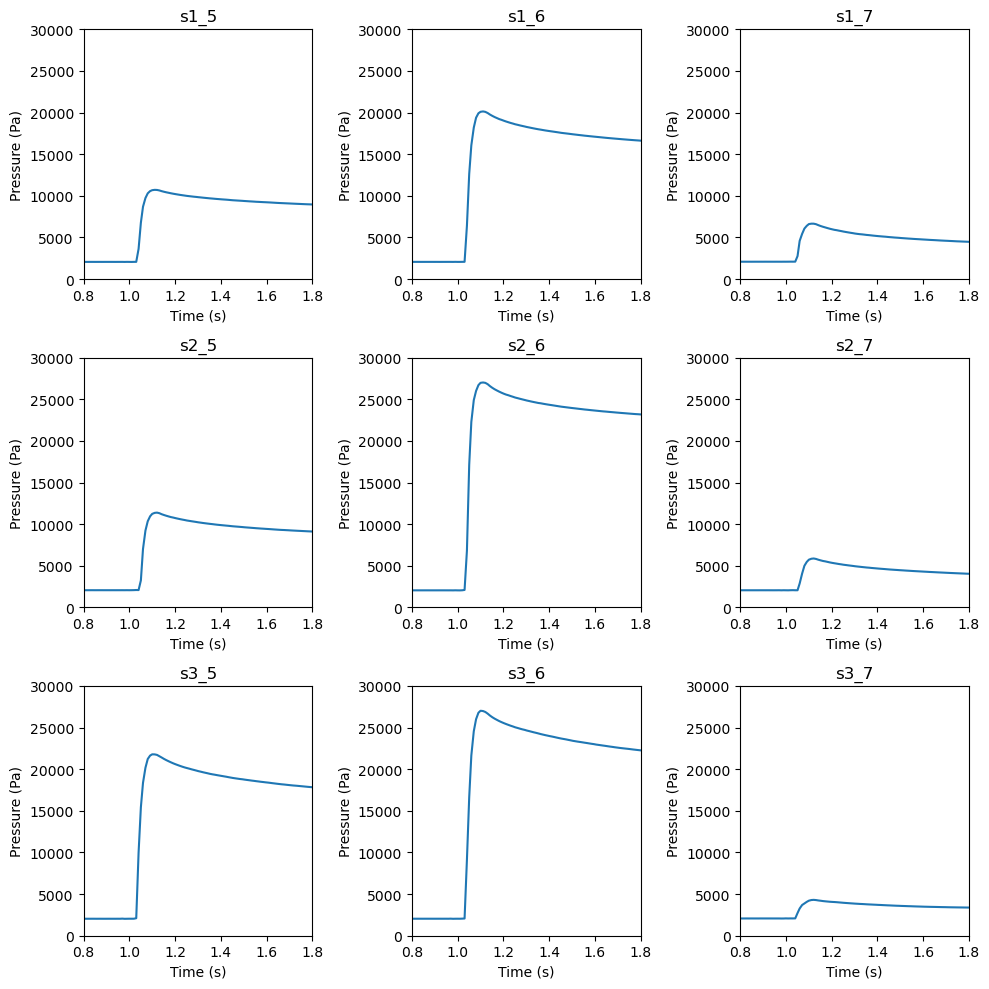

In [53]:
# PLOT FOR 3X3 GRID AROUND S2_6

fig, ax = plt.subplots(3,3, figsize=(10,10))
sensors = ["s1_5", "s1_6", "s1_7", "s2_5", "s2_6", "s2_7", "s3_5", "s3_6", "s3_7"]

for i in range(3):
    for j in range(3):
        sensor_to_plot = sensors[i*3+j]
        ax[i,j].plot(data[:, key["time"]], data[:, key[sensor_to_plot]])
        ax[i,j].set_title(sensor_to_plot)
        ax[i,j].set_xlim(0.8, 1.8)
        ax[i,j].set_ylim(0, 30000)
        ax[i,j].set_xlabel("Time (s)")
        ax[i,j].set_ylabel("Pressure (Pa)")

plt.tight_layout()
plt.show()

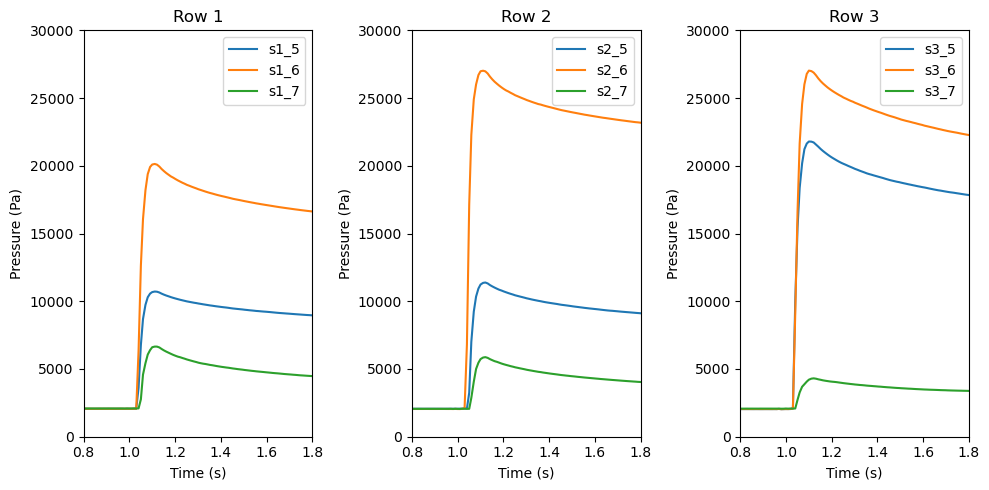

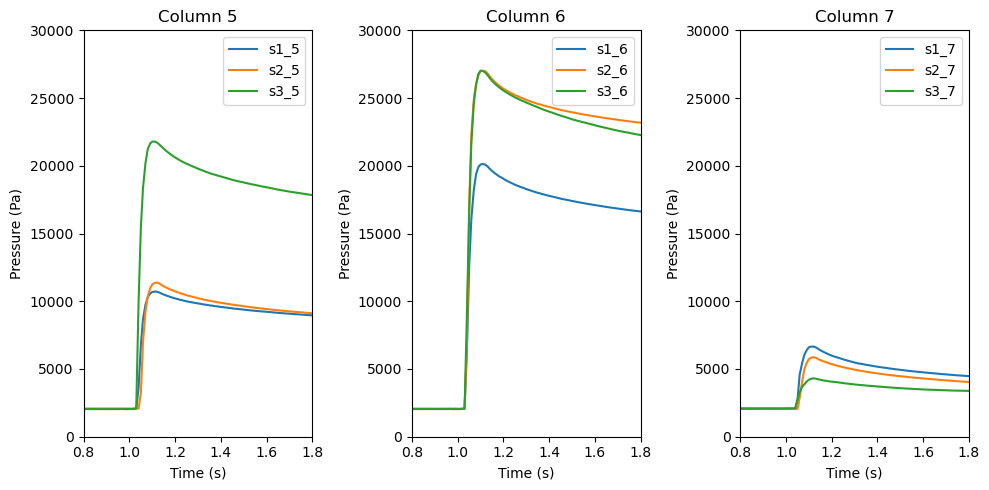

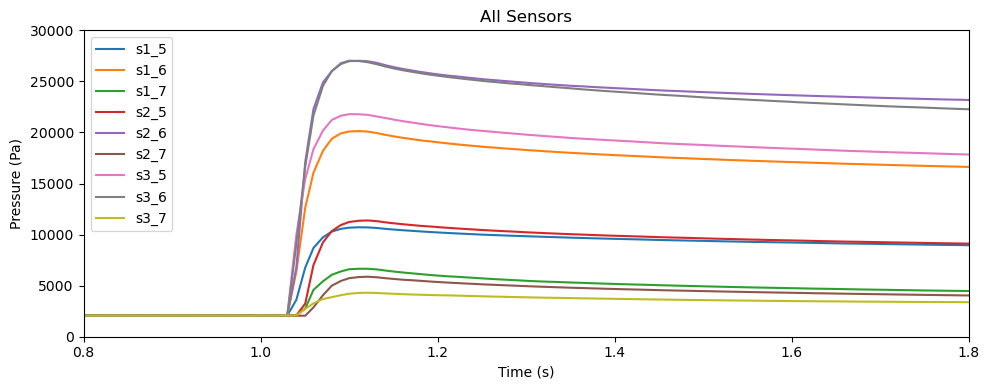

In [99]:
# PLOT SAME 9 SENSORS BY ROW, BY COLUMN, ALL TOGETHER

# sensor indexing: si_j = row i, column j

# by row (1, 2, 3)
fig, ax = plt.subplots(1,3, figsize=(10,5))
for i in range(3):
    ax[i].plot(data[:, key["time"]], data[:, key[sensors[i*3]]], label=sensors[i*3])
    ax[i].plot(data[:, key["time"]], data[:, key[sensors[i*3+1]]], label=sensors[i*3+1])
    ax[i].plot(data[:, key["time"]], data[:, key[sensors[i*3+2]]], label=sensors[i*3+2])
    ax[i].set_title("Row "+str(i+1))
    ax[i].set_xlim(0.8, 1.8)
    ax[i].set_ylim(0, 30000)
    ax[i].legend()
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Pressure (Pa)")
plt.tight_layout()
plt.show()

# by column (5, 6, 7)
fig, ax = plt.subplots(1,3, figsize=(10,5))
for i in range(3):
    ax[i].plot(data[:, key["time"]], data[:, key[sensors[i]]], label=sensors[i])
    ax[i].plot(data[:, key["time"]], data[:, key[sensors[i+3]]], label=sensors[i+3])
    ax[i].plot(data[:, key["time"]], data[:, key[sensors[i+6]]], label=sensors[i+6])
    ax[i].set_title("Column "+str(i+5))
    ax[i].set_xlim(0.8, 1.8)
    ax[i].set_ylim(0, 30000)
    ax[i].legend()
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Pressure (Pa)")
plt.tight_layout()
plt.show()

# all together
fig, ax = plt.subplots(1,1, figsize=(10,4))
for i, s in enumerate(sensors):
    ax.plot(data[:, key["time"]], data[:, key[s]], label=s)
ax.set_title("All Sensors")
ax.set_xlim(0.8, 1.8)
ax.set_ylim(0, 30000)
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Pressure (Pa)")
plt.tight_layout()
plt.show()

['s1_5', 's1_6', 's1_7', 's2_5', 's2_6', 's2_7', 's3_5', 's3_6', 's3_7']
[10717. 20136.  6654. 11384. 27019.  5874. 21792. 27027.  4309.]
[4.559082 5.175781 1.90918  4.488525 3.356201 1.566406 3.407714 3.720947
 1.778808]


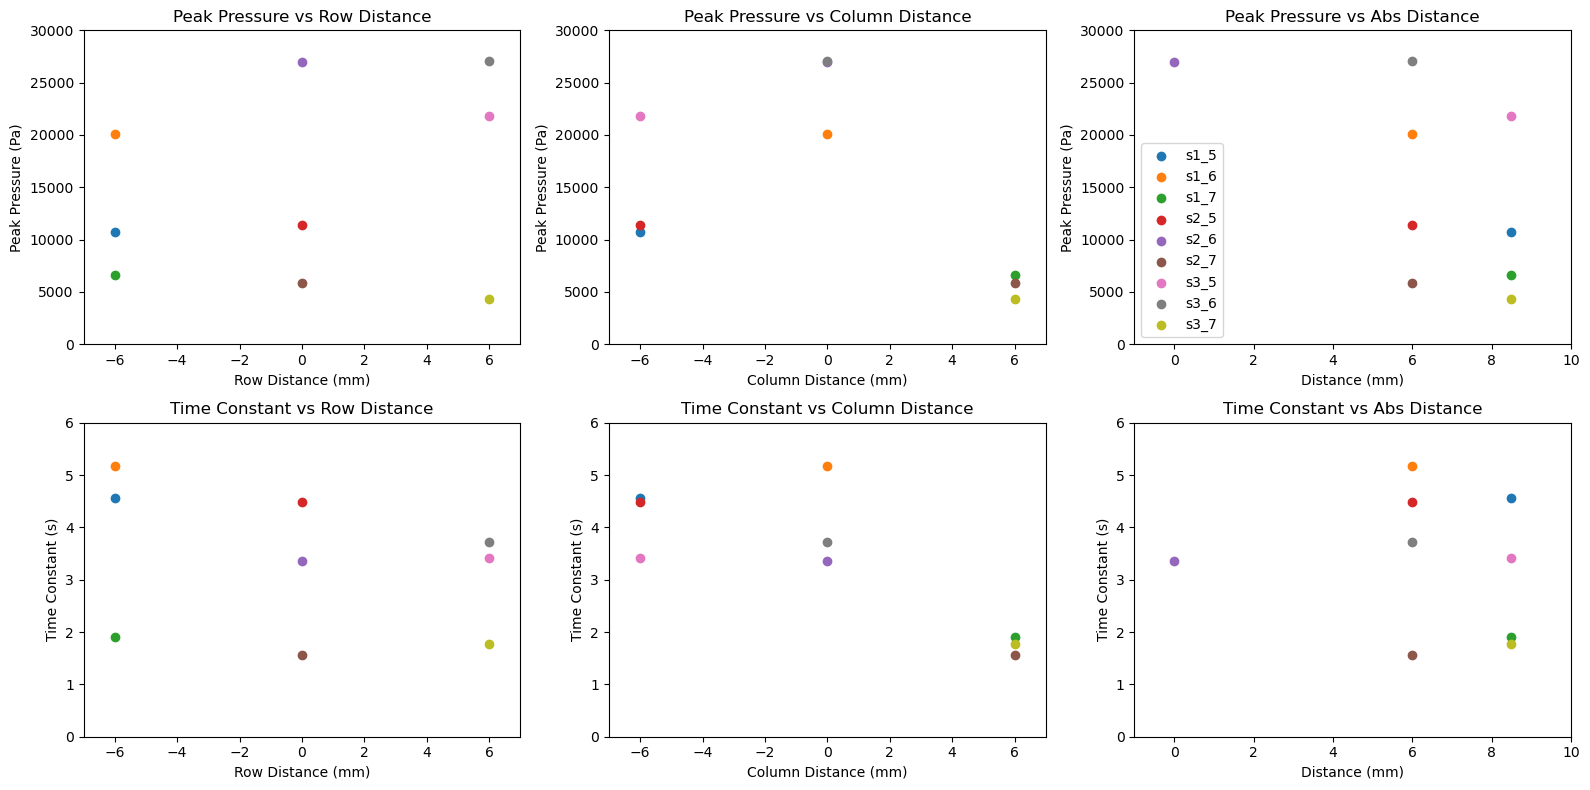

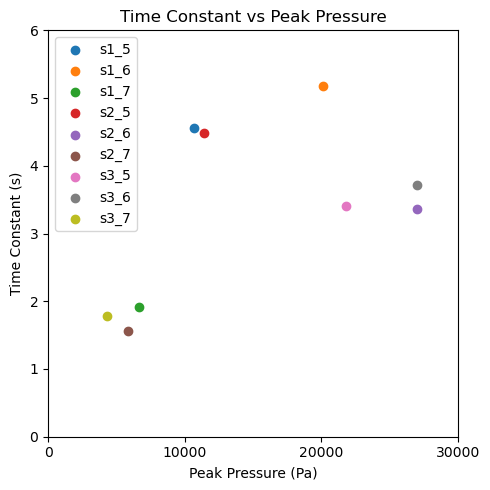

In [127]:
# SCATTER PLOTS OF PEAK PRESSURE, TIME CONSTANTS VS DISTANCE FROM S2_6

# get all of the time constants and peak pressures
time_consts = np.zeros(len(sensors))
max_pressures = np.zeros(len(sensors))
for i, s in enumerate(sensors):
    max_pressure = np.max(data[:, key[s]])
    max_pressures[i] = max_pressure
    max_pressure_idx = np.argmax(data[:, key[s]])
    max_pressure_time = data[max_pressure_idx, key["time"]]
    stable_pressure = np.mean(data[(data[:, key["time"]] > 60.0) & (data[:, key["time"]] < 61.0), key[s]])
    one_tc_pressure = stable_pressure + (1.0-0.632)*(max_pressure - stable_pressure)
    one_tc_pressure_idx = np.argmin(np.abs(data[:, key[s]] - one_tc_pressure))
    time_const_est = data[one_tc_pressure_idx, key["time"]] - max_pressure_time
    # print("Estimated time constant for "+s+": "+str(time_const_est)+" seconds.")
    time_consts[i] = time_const_est
print(sensors)
print(max_pressures)
print(time_consts)

# calculate distances
# sensor indexing: si_j = row i, column j
rows = np.array([1, 1, 1, 2, 2, 2, 3, 3, 3])
cols = np.array([5, 6, 7, 5, 6, 7, 5, 6, 7])
row_distances = np.array([-1, -1, -1, 0, 0, 0, 1, 1, 1]) * 6.0
col_distances = np.array([-1, 0, 1, -1, 0, 1, -1, 0, 1]) * 6.0
abs_distances_mm = np.sqrt(row_distances**2 + col_distances**2)


# scatter plot for peak pressure and time constant vs row distance, col distance, and absolute distance
fig, ax = plt.subplots(2,3, figsize=(16,8))
for i in range(len(sensors)):
    ax[0,0].scatter(row_distances[i], max_pressures[i], label=sensors[i])
    ax[1,0].scatter(row_distances[i], time_consts[i], label=sensors[i])
    ax[0,1].scatter(col_distances[i], max_pressures[i], label=sensors[i])
    ax[1,1].scatter(col_distances[i], time_consts[i], label=sensors[i])
    ax[0,2].scatter(abs_distances_mm[i], max_pressures[i], label=sensors[i])
    ax[1,2].scatter(abs_distances_mm[i], time_consts[i], label=sensors[i])
ax[0,0].set_xlim(-7.0,7.0)
ax[0,0].set_ylim(0,30000)
ax[0,0].set_title("Peak Pressure vs Row Distance")
ax[0,0].set_xlabel("Row Distance (mm)")
ax[0,0].set_ylabel("Peak Pressure (Pa)")
ax[1,0].set_xlim(-7.0,7.0)
ax[1,0].set_ylim(0,6.0)
ax[1,0].set_title("Time Constant vs Row Distance")
ax[1,0].set_xlabel("Row Distance (mm)")
ax[1,0].set_ylabel("Time Constant (s)")
ax[0,1].set_xlim(-7.0,7.0)
ax[0,1].set_ylim(0,30000)
ax[0,1].set_title("Peak Pressure vs Column Distance")
ax[0,1].set_xlabel("Column Distance (mm)")
ax[0,1].set_ylabel("Peak Pressure (Pa)")
ax[1,1].set_xlim(-7.0,7.0)
ax[1,1].set_ylim(0,6.0)
ax[1,1].set_title("Time Constant vs Column Distance")
ax[1,1].set_xlabel("Column Distance (mm)")
ax[1,1].set_ylabel("Time Constant (s)")
ax[0,2].set_xlim(-1,10)
ax[0,2].set_ylim(0,30000)
ax[0,2].set_title("Peak Pressure vs Abs Distance")
ax[0,2].set_xlabel("Distance (mm)")
ax[0,2].set_ylabel("Peak Pressure (Pa)")
ax[0,2].legend()
ax[1,2].set_xlim(-1,10)
ax[1,2].set_ylim(0,6.0)
ax[1,2].set_title("Time Constant vs Abs Distance")
ax[1,2].set_xlabel("Distance (mm)")
ax[1,2].set_ylabel("Time Constant (s)")
plt.tight_layout()
plt.show()


# scatter plots, shared color between both plots
fig, ax = plt.subplots(1,1, figsize=(5,5))
for i in range(len(sensors)):
    ax.scatter(max_pressures[i], time_consts[i], label=sensors[i])
ax.set_xlim(0,30000)
ax.set_xticks(np.linspace(0,30000,4))
ax.set_ylim(0,6.0)
ax.set_title("Time Constant vs Peak Pressure")
ax.set_xlabel("Peak Pressure (Pa)")
ax.set_ylabel("Time Constant (s)")
ax.legend()

plt.tight_layout()
plt.show()